In [8]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import scipy
import scipy.ndimage.filters

In [2]:
#pip install nengo

In [3]:
#pip install  nengo-ocl

In [9]:
from nengo.utils.matplotlib import rasterplot
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray
def get_image_channels(rgb):

    r, g, b = 1.0*rgb[:,:,0], 1.0*rgb[:,:,1], 1.0*rgb[:,:,2]
    return r,g,b    
  
def norm_image(input):
    a = input -np.min(input)
    return a/np.max(a)
    
def max_change_result(data,image_name):
    max_itr = 2000
    max_changes = np.zeros(max_itr)

    for i in range(1,max_itr):
        max_changes[i-1] = np.max(np.abs(data[i]-data[i-1]))
    np.save('ac_feedback_'+ image_name +'_max_changes.npy',max_changes)   


def save_feedback_results(data,image_name):
    itrs = np.array([10,20,30,40,50,100,200,300,1000])
    for t in itrs:
        #out = np.reshape(sim.data[img_out][t], (h, w))
        out = np.reshape(data[t], (h, w))
        plt.figure()
        plt.imshow(out,cmap = 'gray')
        
        path =  'ac_feedback_' + image_name + '_' + str(t) + '.png'
        mpimg.imsave(path,out,cmap='gray')
    np.save('ac_feedback_'+ image_name+ '.npy',data[0:300])
    max_change_result(data,image_name)

def save_spikes(data,image_name,n,title):
    t = 500
    center_pixels = np.arange(np.round(n/2)-50,np.round(n/2)+50,dtype=np.int32)
    fig, ax = plt.subplots(1, 1, sharex=True  )
    

    ax.set_title(title + ": Spikes Raster")
    rasterplot(np.arange(t),data[0:t,center_pixels], ax=ax)
    ax.set_ylabel("Neuron #")
    ax.set_xlabel("Time (ms)")
    fig.show()
    plt.savefig('ac_feedback_Spikes_Raster_'+image_name+ '_' + str(t) +'.png')
    np.save('ac_feedback_spikes_'+ image_name+ '.npy',data[0:t])



In [10]:
import nengo
import nengo_ocl


# creates convolution layer
def conv_filter2d(w_filter1,n_neurons_ens):
    
    #creates the convolution transformation (weights)
    conv = nengo.Convolution(n_filters =1, input_shape=(h,w,1), kernel_size=tuple([3,3]),  strides=tuple([1,1]),  padding='same', channels_last=True,init= w_filter1)
    
    layer = nengo.networks.EnsembleArray(n_neurons_ens, conv.output_shape.size,                                         
                                         
                                         neuron_type= nengo.SpikingRectifiedLinear()
                                         )
                      
    return layer,conv
# 
def LaplaceNet(input,n,n_neurons_ens,tau):
    w_filter = x = np.array([[0, 1, 0], [1, -4, 1],[0, 1, 0]])
    w_filter1 =1* w_filter[:,:,None,None] 
    with nengo.Network() as laplaceSolver:


        def stim(t):           
                return np.array(-1*scipy.ndimage.filters.laplace(input).flatten())

        laplaceSolver.input =  nengo.Node(stim,size_out=n)
       
        laplaceSolver.layer_on,conv_on = conv_filter2d(w_filter1,n_neurons_ens)        
        nengo.Connection(laplaceSolver.input, laplaceSolver.layer_on.input,transform=tau)
        
        nengo.Connection(laplaceSolver.layer_on.output, laplaceSolver.layer_on.input,transform=conv_on)
        nengo.Connection(laplaceSolver.layer_on.output, laplaceSolver.layer_on.input,transform=1)
        laplaceSolver.output = nengo.Node(size_in=n ,size_out=n )
        nengo.Connection(laplaceSolver.layer_on.output, laplaceSolver.output)
        
        
        
    return laplaceSolver


In [11]:
def run_feedback_model(input_img,image_name,title):

    # model parameters
    tau = 1.9/4
    h,w = input_img.shape
    n = h*w
    
    n_neurons_ens = 10

    net = nengo.Network()
    with net:
        net.img   = LaplaceNet(255*input_img,n,n_neurons_ens,tau)
        img_out = nengo.Probe(net.img.output)
        net.img.layer_on.add_neuron_output()
        img_spikes =  nengo.Probe(net.img.layer_on.neuron_output, synapse=None)
    print(net.n_neurons)    
        
    with nengo.Simulator(net,progress_bar =False) as sim:
        sim.run(2)    

    save_feedback_results(sim.data[img_out],image_name)
    save_spikes(sim.data[img_spikes],image_name,n,title)

    return sim.data[img_out],sim.data[img_spikes]

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/nengo/node.py:63: UserWarning: 'Node.size_out' is being overwritten with 'Node.size_in' since 'Node.output=None'
  "'Node.size_out' is being overwritten with "
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/nengo/node.py:63: UserWarning: 'Node.size_out' is being overwritten with 'Node.size_in' since 'Node.output=None'
  "'Node.size_out' is being overwritten with "
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


75000
98000


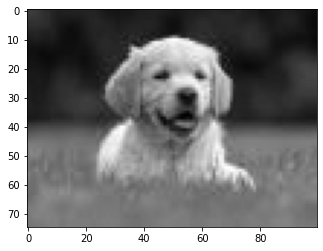

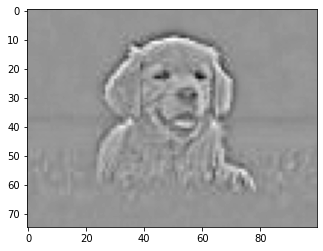

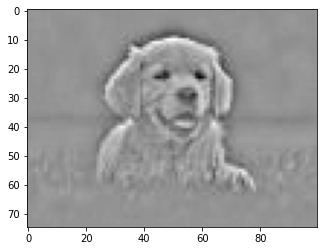

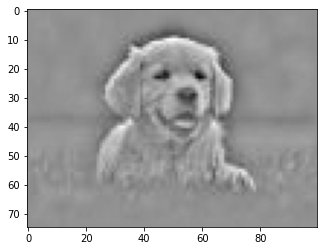

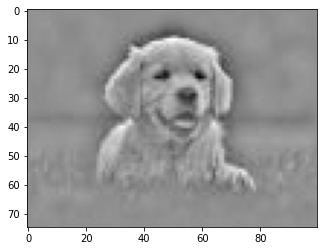

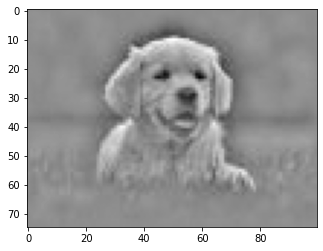

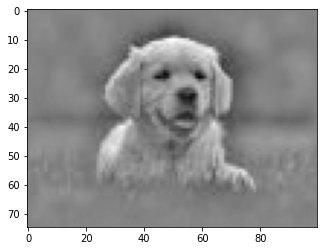

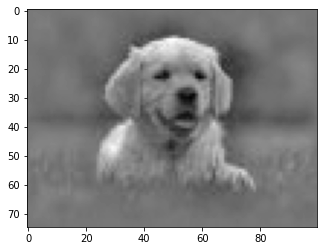

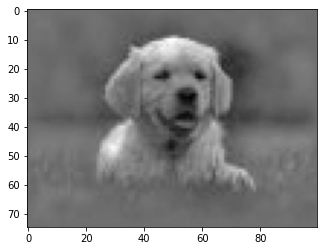

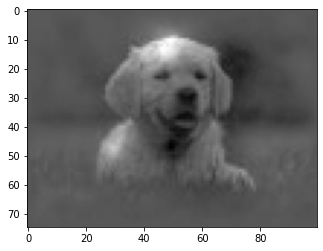

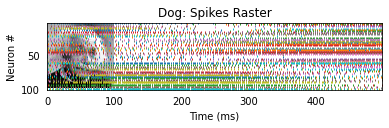

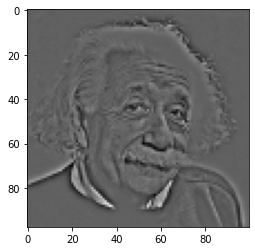

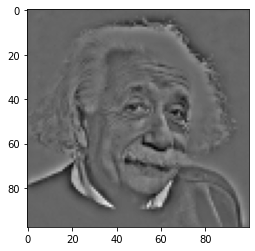

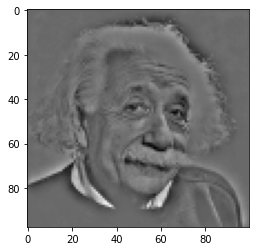

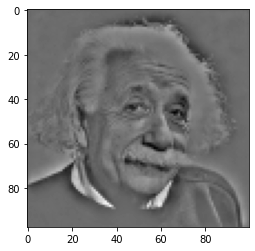

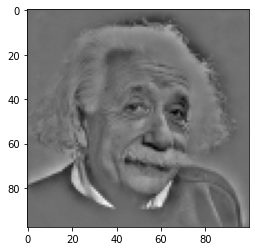

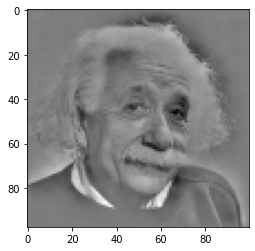

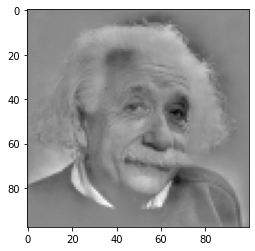

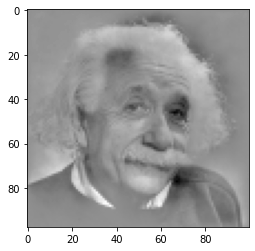

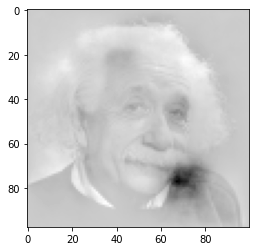

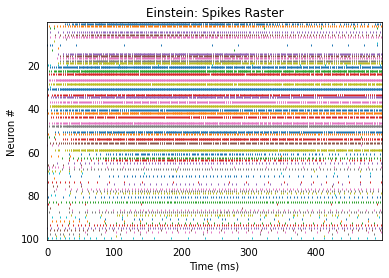

In [12]:
image_list = []
image_list.append(['black_squre_100_97','png','Black square'])
image_list.append(['dog_p_100_75','jpg','Dog'])
image_list.append(['einstein_p_100_98','png','Einstein'])
image_list.append(['BerryJ_100_67','jpg','Landscape'])

for inx in range(len(image_list)):

    # read image
    img_name = image_list[inx][0]
    img_ext = image_list[inx][1]
    img_title = image_list[inx][2]
    img_path = img_name +'.' + img_ext
    img = rgb2gray(mpimg.imread(img_path) )
    img = img/np.max(img)
    plt.imshow(img, cmap='gray')
    h,w = img.shape

    data1,data2 = run_feedback_model(img,img_name,img_title)